In [1]:
# Import Optimization Libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# Import General Libraries
import sympy as sym
import numpy as np
from IPython.display import display 

# Create a Concrete m
m = Concretem()

In [2]:
Nodes = 120
TT = 0.25
Damping_val = 36.8 
BB_extend = 160.3
BB_retract = 132.6
BB_force = 1

profile = 3   # 1 - full profile
              # 2 - half profile
              # 3 - retract full
              # 4 - retract half
              # 5 - half stop

# Nodes
kNodes = 12   #number of buckets
m.kNodes = range(1,kNodes)
m.Nodes = range(0,Nodes)

In [3]:
m.X0 = Param(initialize = 0.0) # position of fixed base
m.Y0 = Param(initialize = 0.0)
m.h = Var(m.Nodes) # time step

m.Damping = Param(initialize = Damping_val)  # Damping coefficient
m.mass = Param(initialize = 0.1399) # mass of the 'mass'

# Initailize Position, Velocity and Acceleration
m.x1 = Var(m.Nodes)
m.dx1 = Var(m.Nodes)
m.ddx1 = Var(m.Nodes)

# Define Contact Force
m.F_a_ext_L = Var(m.Nodes)
m.F_a_rtn_L = Var(m.Nodes)
m.L_max = Param(initialize = 0.125)
m.L_min = Param(initialize = 0)
m.eps = Param(initialize = 1000.0, mutable = True)

###########################################################################################
m.F_a_pos_L = Var(m.Nodes) # new
m.F_a_neg_L = Var(m.Nodes) # new
m.kSlack_pos_L = Var(m.Nodes) # bucket node slack variable
m.kSlack_neg_L = Var(m.Nodes) # bucket node slack variable 

In [4]:
# Intergration Constraints
def BwEuler_p(m,n): # Positions
    if n > 1:
        return m.x1[n] == m.x1[n-1] + m.h[n]*m.dx1[n-1]
    else:
        return Constraint.Skip # Leaves out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.Nodes, rule = BwEuler_p)

def BwEuler_v(m,n): # Velocities
    if n > 1:
        return m.dx1[n] == m.dx1[n-1] + m.h[n]*m.ddx1[n-1]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.Nodes, rule = BwEuler_v)

In [5]:
X0 = sym.symbols('X0')   #starting position of the block
m1 = sym.symbols('m1')   #mass of the block
b1 = sym.symbols('b1')   #damping coefficient

L_max = sym.symbols('L_max')  # Max stroke length
L_min = sym.symbols('L_min')  # Min stroke length

x1 = sym.symbols('x1')                #position of the block
dx1 = sym.symbols('\dot{\\ x}_{1}')    #velocity of the block
ddx1 = sym.symbols('\ddot{\\ x}_{1}')  #acceleration of the block

q = sym.Matrix([x1])
dq = sym.Matrix([dx1])
ddq = sym.Matrix([ddx1])

Xnew = X0 + x1

p1 = sym.Matrix([Xnew, x1])
[dXnew, dx1] = p1.jacobian(q)*dq
#display(p1)             # [original position + current position ; current position]

# Just checking
dp1 = sym.Matrix([dXnew, dx1]) # --> derivative of the p1 matrix
#display(dp1)

######################################################################################################################
######################################################################################################################

#Define kinetic and potential energies for use in Lagrangian
T = sym.Matrix([0.5*m1*(dXnew**2)])
V = sym.Matrix([0]) 
display(T)

# Define damping
Damp = sym.Matrix([b1*dx1])
display(Damp)

#Calculate terms of the Lagrangian Equation
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) 
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq 

Lg3 = T.jacobian(q)

Lg4 = V.jacobian(q) 

#apply a horizontal force
F = sym.symbols('F')                  #applied force parameter
FF = sym.Matrix([[F],[0],[0]])        #force matrix
rF = sym.Matrix([[X0 + Xnew],[0],[0]])  #distance the force acts on the block
JF = rF.jacobian(q)
QF = JF.transpose()*FF
display(QF)
Force = QF

# Complimentarity Forces
F_ext = sym.symbols('F_ext')
Extention = sym.Matrix([F_ext])
F_rtn = sym.symbols('F_rtn')
Retraction = sym.Matrix([F_rtn])


F_pos = sym.symbols('F_pos')
Fpositive = sym.Matrix([F_pos])
F_neg = sym.symbols('F_neg')
Fnegative = sym.Matrix([F_neg])

#Bucket Node Slack Varaibles
#F_kNodes = sym.symbols('F_kNodes')
#buckNodes = sym.Matrix([F_kNodes])
#F_SlackBangPos = sym.symbols('F_SlackBangPos')
#SlackBangPos = sym.Matrix([F_SlackBangPos])
#F_SlackBangNeg = sym.symbols('F_SlackBangNeg')
#SlackBangNeg = sym.Matrix([F_SlackBangNeg])


#Equation of motion
EOM = Lg1 - Lg3 + Lg4 - (-Damp + BB_extend*Fpositive - BB_retract*Fnegative + Retraction - Extention)#+ buckNodes + SlackBangPos - SlackBangNeg) 
display(EOM)

Matrix([[0.5*\dot{ x}_{1}**2*m1]])

Matrix([[\dot{ x}_{1}*b1]])

Matrix([[F]])

Matrix([[F_ext + 132.6*F_neg - 160.3*F_pos - F_rtn + 1.0*\ddot{ x}_{1}*m1 + \dot{ x}_{1}*b1]])

In [6]:
# Lambdify the EOM
func_map = {'sin':sin, 'cos':cos}  
sym_list = [X0, x1, dx1, ddx1, m1, b1, F_ext, F_rtn, F_pos, F_neg]#, F_kNodes, F_SlackBangPos, F_SlackBangNeg]

lambEOM1 = sym.lambdify(sym_list, EOM[0], modules = [func_map])

#display(lambEOM1)

# Create EOM Constraints
def EOM1(m,n): 
    # list the m versions of all quantities in the same order as sym_list
    var_list = [m.X0, m.x1[n], m.dx1[n], m.ddx1[n], m.mass, m.Damping, m.F_a_ext_L[n], 
               m.F_a_rtn_L[n], m.F_a_pos_L[n], m.F_a_neg_L[n]]#, m.kSlack[n], m.slackBangPos[n], m.slackBangNeg[n]] 
    return lambEOM1(*var_list) == 0
m.EOM = Constraint(m.Nodes, rule = EOM1)

In [7]:
# Define Cost Function - minimizing force
def CostFunction(m):
    sum_force = 0
    for n in range(1,Nodes):
            sum_force = sum_force + m.F_a_pos_L[n]**2 + m.F_a_neg_L[n]**2 
    return sum_force

#m.Cost = Objective(rule = CostFunction)

In [8]:
# Cost Function - minimizing time
def CostFunction(m):
    sum_time = 0
    for n in range(1,Nodes):
        sum_time = sum_time + m.h[n]
    return sum_time
m.Cost = Objective(rule = CostFunction)

In [9]:
# Define Variable Bounds
for n in range(1,Nodes):
    lb = 0.1*TT/Nodes
    ub = 1*TT/Nodes
    m.h[n].setlb(lb)
    m.h[n].setub(ub)
    m.x1[n].setlb(0)
    m.x1[n].setub(0.125)
    # Hard stops
    m.F_a_ext_L[n].setlb(0)
    m.F_a_ext_L[n].setub(10)
    m.F_a_rtn_L[n].setlb(0)
    m.F_a_rtn_L[n].setub(10)###was 100 CALLEN 
    
    ############################### NEW STUFF ####################
    m.F_a_pos_L[n].setlb(0)
    m.F_a_pos_L[n].setub(BB_force)
    m.F_a_neg_L[n].setlb(0)
    m.F_a_neg_L[n].setub(BB_force)
    m.kSlack_pos_L[n].setlb(0)
    m.kSlack_pos_L[n].setub(BB_force)
    m.kSlack_neg_L[n].setlb(0)
    m.kSlack_neg_L[n].setub(BB_force)
    ###############################################################

In [10]:
# Initialization of variables
for n in range (1,Nodes):
    m.F_a_ext_L[n].value = 0.01
    m.F_a_rtn_L[n].value = 0.01
    
    ########################### NEW STUFF #########################
    m.F_a_pos_L[n].value = 0
    m.F_a_neg_L[n].value = 0
    m.kSlack_pos_L[n].value = 0
    m.kSlack_neg_L[n].value = 0
    ###############################################################
    
    m.x1[n].value = np.random.uniform(0,0.125)
    m.dx1[n].value = 0.01
    m.ddx1[n].value = 0.01

In [11]:
# Set Boundary Conditions
# Initial Conditions
m.x1[1].fixed = True
m.x1[1].value = 0.125

m.dx1[1].fixed = True
m.dx1[1].value = 0

# Final Conditions
# Nodes-1 ensures it stops at 99, if you just say Nodes jupyter throughs a tantrum
m.x1[Nodes-1].fixed = True 
m.x1[Nodes-1].value = 0.125  # Stop at specified location 

m.dx1[Nodes-1].fixed = True
m.dx1[Nodes-1].value = 0

In [12]:
# Start the Solver
m.eps.value = 1000.0
display(Nodes)
       
for i in range (0,8):

    print(m.eps.value)
    
    def pneumatics_pos(m,n):   # Positive Force Slack Variable
        return (BB_force - m.kSlack_pos_L[n])*(m.kSlack_pos_L[n]) <= m.eps
    m.pneumatics_pos = Constraint(m.kNodes, rule = pneumatics_pos)
    
    def pneumatics_neg(m,n):   # Negative Force Slack Variable
        return (BB_force - m.kSlack_neg_L[n])*(m.kSlack_neg_L[n]) <= m.eps
    m.pneumatics_neg = Constraint(m.kNodes, rule = pneumatics_neg)
    
    def temp_kSlack(m,n):     # Positive and Negative don't occur at same time
        alpha_kSlack = m.kSlack_pos_L[n]
        beta_kSlack = m.kSlack_neg_L[n]
        return alpha_kSlack*beta_kSlack <= m.eps
    m.temp_kSlack = Constraint(m.kNodes, rule = temp_kSlack)
    
    def BucketNode_neg(m,n):  # Negative Bucket Node
        interval = Nodes/kNodes
        nodes = int((n-1)/interval)+1
        if n == Nodes:
            nodes = kNodes      
        if(n <= Nodes):
            return m.F_a_neg_L[n]==m.kSlack_neg_L[nodes]
        else:
            return Constraint.Skip
    m.BucketNode_neg = Constraint(m.Nodes, rule = BucketNode_neg)
    
    def BucketNode_pos(m,n):  # Positive Bucket Node
        interval = Nodes/kNodes
        nodes = int((n-1)/interval)+1
        if n == Nodes:
            nodes = kNodes    
        if(n <= Nodes):
            return m.F_a_pos_L[n]==m.kSlack_pos_L[nodes]  
        else:
            return Constraint.Skip
    m.BucketNode_pos = Constraint(m.Nodes, rule = BucketNode_pos)

    def extension_contact(m,n):
        if(n < Nodes-2):
            alpha_ext = m.L_max - m.x1[n+1]
            beta_ext = m.F_a_ext_L[n]
            return alpha_ext*beta_ext <= m.eps
        else:
            return m.F_a_ext_L[n] == 0
    m.extension_contact = Constraint(m.Nodes, rule = extension_contact)


    def retraction_contact(m,n):
        if (n < Nodes-2):
            alpha_rtn = m.x1[n+1] - m.L_min
            beta_rtn = m.F_a_rtn_L[n]
            return alpha_rtn*beta_rtn <= m.eps
        else:
            return m.F_a_rtn_L[n] == 0
    m.retraction_contact = Constraint(m.Nodes, rule = retraction_contact)

    ########################## BANG-BANG SLACK COMPLEMENTARITY CONSTRAINTS #################################
    def pos_Slack(m,n):
        alpha_pos = (BB_force - m.F_a_pos_L[n])
        beta_pos = m.F_a_pos_L[n]
        return alpha_pos*beta_pos <= m.eps
    m.pos_Slack = Constraint(m.Nodes, rule = pos_Slack)

    def neg_Slack(m,n):
        alpha_neg = (BB_force - m.F_a_neg_L[n])
        beta_neg = m.F_a_neg_L[n]
        return alpha_neg*beta_neg <= m.eps
    m.neg_Slack = Constraint(m.Nodes, rule = neg_Slack)


    def temp_Slack(m,n):
        alpha_temp = m.F_a_pos_L[n]
        beta_temp = m.F_a_neg_L[n]
        return alpha_temp*beta_temp <= m.eps
    m.temp_Slack = Constraint(m.Nodes, rule = temp_Slack)

    ############################################ PROFILES ##################################################
    
    if(profile == 1):
        def full_profile(m,n):
            if(n == (Nodes-2)/2):
                return m.x1[n+1] >= (m.L_max-0.001)
            else:
                return Constraint.Skip
        m.full_profile = Constraint(m.Nodes, rule = full_profile)
        
        def time_forced(m,n):
            if(n == (Nodes-2)/2):
                return sum(m.h[i] for i in range(1,n)) >= 0.042
            else:
                return Constraint.Skip
        m.time_forced = Constraint(m.Nodes, rule = time_forced)
        
    if(profile == 2):
        def half_profile(m,n):
            if(n == (Nodes-2)/2):
                return m.x1[n+1] >= (m.L_max/2)-0.0001
            else:
                return Constraint.Skip
        m.half_profile = Constraint(m.Nodes, rule = half_profile)
    
    
    if(profile == 3):
        def retract_full(m,n):
            if(n == (Nodes-2)/2):
                return m.x1[n+1] <= (m.L_min + 0.0001) 
            else: 
                return Constraint.Skip
        m.retract_full = Constraint(m.Nodes, rule = retract_full)
    
    if(profile == 4):
        def retract_half(m,n):
            if(n == (Nodes-2)/2):
                return m.x1[n+1] <= (m.L_max/2)+0.0001
            else:
                return Constraint.Skip
        m.retract_half = Constraint(m.Nodes, rule = retract_half)
    

    ##############################################################################################

    optimize = SolverFactory('ipopt')

    optimize.options["print_level"] = 0
    optimize.options["max_iter"] = 30000
    optimize.options["max_cpu_time"] = 600
    optimize.options["Tol"] = 1e-6

    results = optimize.solve(m, tee = True) 
    m.eps.value = m.eps.value/10

    m.del_component(m.extension_contact_index)
    m.del_component(m.retraction_contact_index)
    m.del_component(m.pos_Slack_index)
    m.del_component(m.neg_Slack_index)
    m.del_component(m.temp_Slack_index)
    m.del_component(m.pneumatics_pos_index)
    m.del_component(m.pneumatics_neg_index)
    m.del_component(m.temp_kSlack_index)
    m.del_component(m.BucketNode_neg_index)
    m.del_component(m.BucketNode_pos_index)
    
    if(profile == 1):
        m.del_component(m.full_profile_index)
        m.del_component(m.time_forced_index)
    if(profile == 2):
        m.del_component(m.half_profile_index)
    if(profile == 3):
        m.del_component(m.retract_full_index)
    if(profile == 4):
        m.del_component(m.retract_half_index)


120

1000.0
Ipopt 3.13.2: print_level=0
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

100.0
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling

In [13]:
# Some debugging stuff
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.
#m.pprint()

ok
optimal


In [14]:
#animate m --> will be able to see what m is doing by viewing in with HTML
import matplotlib.pyplot as plt
#import matplotlib.animation as ani
#from IPython.display import HTML
#%matplotlib inline

#fig1, ax1 = plt.subplots(1,1)
#def plot_block(i,m,ax): #update function for animation
#    ax.clear()
#    ax.set_xlim([-0.1,0.2])
#    ax.set_ylim([-0.1,0.1])
    
    #plot mass
#    m1topx = m.X0.value   #initial position of mass
#    m1bottomx = m1topx + m.x1[i].value
#    ax.plot([m1bottomx,0],[m1topx,0],color = 'xkcd:red')
#    ax.grid(True)
    
#update = lambda i: plot_block(i,m,ax1)      #lambdify just used to calculate the numerical values fast

#animate = ani.FuncAnimation(fig1,update,range(1,Nodes),interval = 50, repeat = True)

#HTML(animate.to_html5_video())

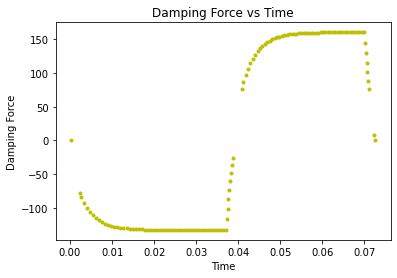

In [15]:
# Damping Force
plt.axes()
Time = 0
for n in range(1,Nodes):
    damping_force = m.Damping.value*m.dx1[n].value
    time = m.h[n].value
    Time += time
    #print(Time)
    #print(force)
    plt.plot(Time,damping_force,'y.')
    plt.xlabel('Time')
    plt.ylabel('Damping Force')
    plt.title('Damping Force vs Time')

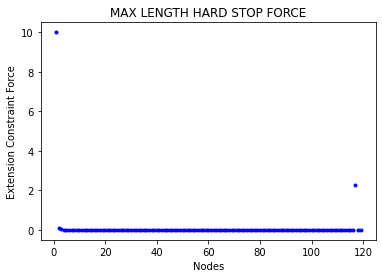

In [16]:
# Extension Constraint Force
plt.axes()
Time = 0
for n in range(1,Nodes):
    ext_force = m.F_a_ext_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Extension Constraint Force')
    plt.title('MAX LENGTH HARD STOP FORCE')

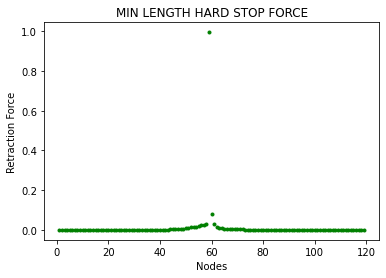

In [17]:
# Retraction Constraint Force  
plt.axes()  
Time = 0
for n in range(1,Nodes):
    rtn_force = m.F_a_rtn_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,rtn_force, 'g.')
    plt.xlabel('Nodes')
    plt.ylabel('Retraction Force')
    plt.title('MIN LENGTH HARD STOP FORCE')

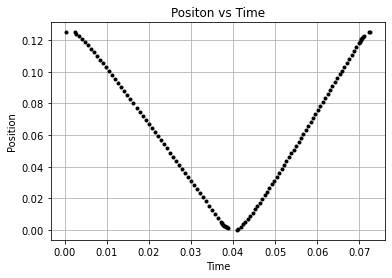

In [18]:
# Position vs Time
plt.axes()
plt.grid(True)
Time = 0    
for n in range(1,Nodes):
    position = m.x1[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(Time,position,'k.')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Positon vs Time')
#plt.savefig('Position_retraction.png')

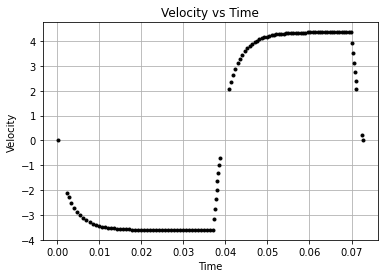

In [19]:
#Velocity vs Time
plt.axes()
Time = 0
plt.grid(True)
for n in range(1,Nodes):
    velocity = m.dx1[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(Time,velocity,'k.')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.title('Velocity vs Time')
#plt.savefig('Velocity_retraction.png')

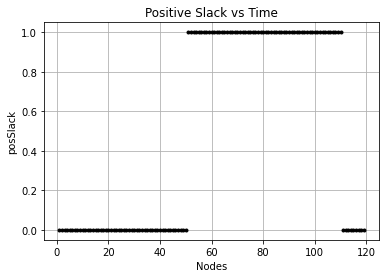

In [20]:
# Positive Slack
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,Nodes):
    posSlack = m.F_a_pos_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,posSlack,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('posSlack')
    plt.title('Positive Slack vs Time')

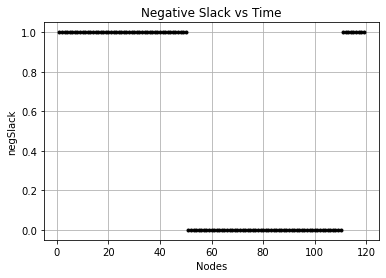

In [21]:
# Negative Slack
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,Nodes):
    negSlack = m.F_a_neg_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,negSlack,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('negSlack')
    plt.title('Negative Slack vs Time')

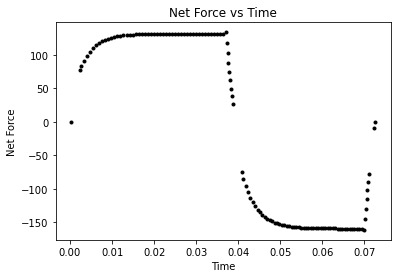

In [22]:
# Net Force
plt.axes()
Time = 0
for n in range (1,Nodes):
    force = m.F_a_pos_L[n].value-m.F_a_neg_L[n].value-m.Damping*m.dx1[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(Time,force,'k.')
    plt.xlabel('Time')
    plt.ylabel('Net Force')
    plt.title('Net Force vs Time')

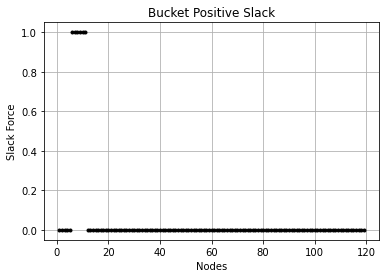

In [23]:
# kSlack Pos
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,Nodes):
    Slack = m.kSlack_pos_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,Slack,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Slack Force')
    plt.title('Bucket Positive Slack')

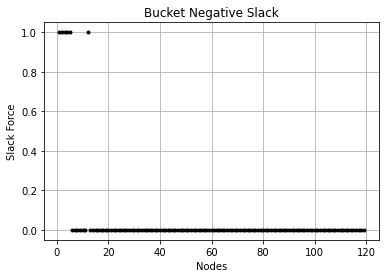

In [24]:
# kSlack Pos
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,Nodes):
    Slack = m.kSlack_neg_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,Slack,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Slack Force')
    plt.title('Bucket Negative Slack')

In [25]:
# Print values to text file
Time = 0
for n in range (1,Nodes):
    time = m.h[n].value
    force = m.F_a_pos_L[n].value-m.F_a_neg_L[n].value-m.Damping*m.dx1[n].value
    Time += time
    print(m.x1[n].value, m.dx1[n].value, force, Time)
    


0.125 0 -0.9999359456658252 0.00020841423801657596
0.125 -2.122086403752958 77.09284371244303 0.0022905453699870603
0.12412791486219187 -2.2824445661086044 82.99402408713081 0.002701501840122241
0.12268781685245422 -2.5017547176832076 91.0646376650762 0.003332447288477521
0.12093501646748371 -2.7047920107272088 98.53641004909545 0.0040330756809242915
0.11898908906583244 -2.874825497452692 104.79364236059322 0.004752512663570317
0.11690239802174882 -3.0138943639321187 109.91137664703614 0.005478362300980613
0.1147063321272575 -3.126835274687445 114.06760216283215 0.006207009569199927
0.11242340801021503 -3.218306192911213 117.4337319534668 0.006937116503761099
0.11007093127382389 -3.2922930957499954 120.156449977934 0.0076680838497722136
0.10766255659783286 -3.3520961539891436 122.35720729581418 0.008399602765605604
0.10525334883610107 -3.3995408399564444 124.10317173941084 0.009118319547888238
0.10280920148897313 -3.438027417156804 125.51947778038408 0.009837283508655384
0.100336756638